# Gerando novos indicadores
Nesse notebook vamos preparar os dados que utilizaremos ao longo do desenvolvimento do projeto. Os datasets aqui utilizados são importados do portal de dados abertos da UFRN (http://dados.ufrn.br/).

Para esse estudo, analisaremos apenas os dados do curso de Ciência e Tecnologia da UFRN, mais espeficamente a disciplina de Cálculo 2, onde tentaremos prever as possiveis reprovações dos alunos se baseando em seu histórico e na nota da primeira unidade na disciplina.

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# importando os dados
matriculas = pd.read_csv("data/matriculas_geral_pos_preparacao.csv", sep=';')
turmas = pd.read_csv("data/turmas_geral_pos_preparacao.csv", sep=';')

## Cálculando a média de reprovação por turma

In [3]:
matriculas.reprovou.sum()

29139

In [4]:
matriculas.shape

(46248, 9)

In [5]:
18834 / 34473

0.5463406143938735

In [6]:
matriculas.columns

Index(['discente', 'faltas_unidade', 'id_turma', 'media_final', 'nota',
       'numero_total_faltas', 'reposicao', 'unidade', 'reprovou'],
      dtype='object')

In [12]:
matriculas.media_final = matriculas.media_final.apply(lambda x: float(x.replace(",", ".")))

In [13]:
statisticas_turmas = matriculas.groupby('id_turma').agg({'reprovou': ['sum', 'count'], 'media_final': ['mean', 'std']})

# Feature 1: dificuldade_professor

In [27]:
def get_dificuldade_prod(row):
    stats_reprovou = statisticas_turmas['reprovou']
    if stats_reprovou["sum"].get(row) and  stats_reprovou['count'].get(row):
        return stats_reprovou["sum"].get(row) /  stats_reprovou['count'].get(row)
    else:
        return np.nan

In [29]:
turmas['tx_reprovacao'] = turmas.id_turma.apply(get_dificuldade_prod)

In [22]:
statisticas_turmas["reprovou"]["sum"].get("57595065")

<AxesSubplot:>

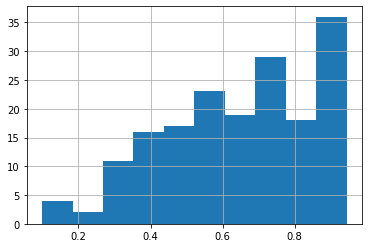

In [30]:
turmas.tx_reprovacao.hist()

In [33]:
turmas.ano_periodo = turmas.ano_periodo.apply(lambda x: int(x.split("_")[1] + x[-1]))

In [54]:
lista_semestres_analisados = [20181, 20182, 20191, 20192]

tx_reprovacao_do_professor_por_turma = {}
for semestre in lista_semestres_analisados:
    turmas_anteriores = turmas.query(f"ano_periodo < {semestre}")
    
    turmas_atuais = turmas.query(f"ano_periodo == {semestre}")
    for index, row in turmas_atuais.iterrows():
        turmas_do_professor = turmas_anteriores[turmas_anteriores.id_docente_interno == row.id_docente_interno]
        if turmas_do_professor.shape[0] > 0:
            tx_reprovacao_do_professor_por_turma[row['id_turma']] = turmas_do_professor.tx_reprovacao.mean()

In [55]:
turmas['professor_tx_reprovao'] = turmas.id_turma.apply(lambda x: tx_reprovacao_do_professor_por_turma[x] if x in tx_reprovacao_do_professor_por_turma.keys() else -1)

### Análise dos professores

In [37]:
prof = pd.read_csv("data/docentes.csv", sep=';')

In [38]:
prof.columns

Index(['siape', 'nome', 'sexo', 'formacao', 'tipo_jornada_trabalho', 'vinculo',
       'categoria', 'classe_funcional', 'id_unidade_lotacao', 'lotacao',
       'admissao'],
      dtype='object')

In [39]:
id_profs = turmas.id_docente_interno.unique()

In [39]:
# prof[prof.id_servidor.isin(id_profs)]

In [18]:
# turmas.id_docente_interno.value_counts()

# Feature 2: desempenho_exatas

In [56]:
id_turmas_c2 = turmas[turmas.id_componente_curricular.isin(['48584', 57588, '2051052'])].id_turma.unique()

matriculas_c2 = matriculas[matriculas.id_turma.isin(id_turmas_c2)]
matriculas_anteriores = matriculas[~matriculas.id_turma.isin(id_turmas_c2)]

In [57]:
# Pegando apenas nota da primeira unidade
matriculas_c2 = matriculas_c2.query(f"unidade == 1")

In [47]:
matriculas_c2.head()

,discente,faltas_unidade,id_turma,media_final,nota,numero_total_faltas,reposicao,unidade,reprovou
1611,f60253715011003f563485ce1bc13ec0,0.0,57595153,5.1,"6,3",2.0,False,1.0,False
1615,dc0ee978e7c49c9b6dc530a760e5903e,0.0,57595153,1.0,"3,0",4.0,False,1.0,True
1617,005826163b7c91f427b5b9e4b02edefd,0.0,57595153,0.0,"0,0",10.0,False,1.0,True
1620,6c0b198c6f5448d08d496d01af4f77ac,0.0,57595153,3.6,"3,7",4.0,False,1.0,True
1623,d6a69c724437038f1823910884094190,0.0,57595153,1.7,"4,7",2.0,False,1.0,True


In [125]:
# matriculas_c2.at[126, 'desempenho_exatas'] = 2

In [58]:
matriculas_c2['desempenho_exatas'] = -1

In [59]:
lista_semestres_analisados = [20181, 20182, 20191, 20192]

tx_reprovacao_do_professor_por_turma = {}
for semestre in lista_semestres_analisados:
    turmas_anteriores = turmas.query(f"ano_periodo < {semestre}")
    matr_antigas = matriculas_anteriores[matriculas_anteriores.id_turma.isin(turmas_anteriores.id_turma.unique())]
    
    turmas_atuais = turmas.query(f"ano_periodo == {semestre}")
    matricula_atual = matriculas_c2[matriculas_c2.id_turma.isin(turmas_atuais.id_turma.unique())]
    for index, row in matricula_atual.iterrows():
        aluno_matr_ant = matr_antigas[matr_antigas.discente == row['discente']]
        
        
        if aluno_matr_ant.shape[0] > 0:
            matriculas_c2.at[index, 'desempenho_exatas'] = round(aluno_matr_ant.media_final.mean(), 2)
        else:
            matriculas_c2.at[index, 'desempenho_exatas'] = -1

<AxesSubplot:>

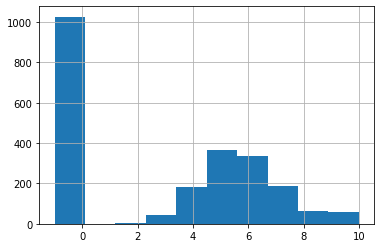

In [60]:
matriculas_c2.desempenho_exatas.hist()

In [61]:
media_desempenho_exatas = matriculas_c2[matriculas_c2.desempenho_exatas != -1].desempenho_exatas.mean()

matriculas_c2.desempenho_exatas = matriculas_c2.desempenho_exatas.apply(lambda x: media_desempenho_exatas if x == -1 else x)

# Feature 3: historico_reprovacao
taxa de reprovação nas disciplinas de cálculo.

In [62]:
matriculas_c2['historico_reprovacao'] = -1

In [63]:
lista_semestres_analisados = [20181, 20182, 20191, 20192]

tx_reprovacao_do_professor_por_turma = {}
for semestre in lista_semestres_analisados:
    turmas_anteriores = turmas.query(f"ano_periodo < {semestre}")
    matr_antigas = matriculas[matriculas.id_turma.isin(turmas_anteriores.id_turma.unique())]
    
    turmas_atuais = turmas.query(f"ano_periodo == {semestre}")
    matricula_atual = matriculas_c2[matriculas_c2.id_turma.isin(turmas_atuais.id_turma.unique())]
    for index, row in matricula_atual.iterrows():
        aluno_matr_ant = matr_antigas[matr_antigas.discente == row['discente']]
        if aluno_matr_ant.shape[0] > 0:
            matriculas_c2.at[index, 'historico_reprovacao'] = sum(aluno_matr_ant.reprovou) / aluno_matr_ant.shape[0]

<AxesSubplot:>

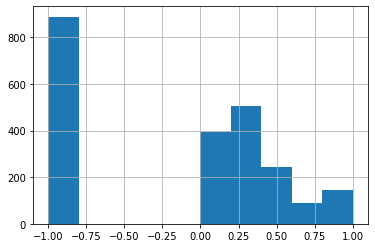

In [64]:
matriculas_c2.historico_reprovacao.hist()

# Feature 4: primeira_vez_pagando
Quantas vezes já pagou C2.

In [65]:
matriculas_c2['primeira_vez_pagando'] = 0

In [66]:
lista_semestres_analisados = [20181, 20182, 20191, 20192]

tx_reprovacao_do_professor_por_turma = {}
for semestre in lista_semestres_analisados:
    turmas_anteriores = turmas.query(f"ano_periodo < {semestre}")
    matr_antigas = matriculas_c2[matriculas_c2.id_turma.isin(turmas_anteriores.id_turma.unique())]
    
    turmas_atuais = turmas.query(f"ano_periodo == {semestre}")
    matricula_atual = matriculas_c2[matriculas_c2.id_turma.isin(turmas_atuais.id_turma.unique())]
    for index, row in matricula_atual.iterrows():
        aluno_matr_ant = matr_antigas[matr_antigas.discente == row['discente']]
        
        matriculas_c2.at[index, 'primeira_vez_pagando'] = aluno_matr_ant.shape[0]

<AxesSubplot:>

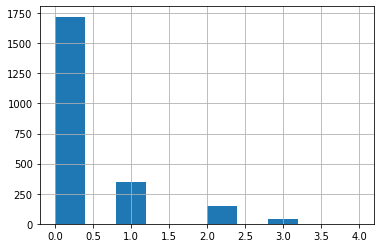

In [67]:
matriculas_c2.primeira_vez_pagando.hist()

# Feature 5: desvio_padra_para_turma
Quão boa foi a nota da primeira unidade, comparado com a nota da turma.

In [68]:
def nota_em_relacao_a_turma(nota, id_turma):
    media_turma = statisticas_turmas['media_final']['mean'][id_turma]
    desvio_padrao = statisticas_turmas['media_final']['std'][id_turma]
    
    if desvio_padrao > 0:
        return (nota - media_turma) / desvio_padrao
    return (nota - media_turma)

In [71]:
matriculas_c2.nota = matriculas_c2.nota.apply(lambda x: float(x.replace(",", ".")))

In [72]:
matriculas_c2['n1_std_turma'] = matriculas_c2.apply(lambda x: nota_em_relacao_a_turma(x['nota'], x['id_turma']), axis=1)

# Feature 6: nota_unidade1

In [73]:
matriculas_c2.head()

,discente,faltas_unidade,id_turma,media_final,nota,numero_total_faltas,reposicao,unidade,reprovou,desempenho_exatas,historico_reprovacao,primeira_vez_pagando,n1_std_turma
1611,f60253715011003f563485ce1bc13ec0,0.0,57595153,5.1,6.3,2.0,False,1.0,False,5.810736,-1.0,0,1.429732
1615,dc0ee978e7c49c9b6dc530a760e5903e,0.0,57595153,1.0,3.0,4.0,False,1.0,True,5.810736,-1.0,0,-0.213393
1617,005826163b7c91f427b5b9e4b02edefd,0.0,57595153,0.0,0.0,10.0,False,1.0,True,5.810736,-1.0,0,-1.707143
1620,6c0b198c6f5448d08d496d01af4f77ac,0.0,57595153,3.6,3.7,4.0,False,1.0,True,5.810736,-1.0,0,0.135149
1623,d6a69c724437038f1823910884094190,0.0,57595153,1.7,4.7,2.0,False,1.0,True,5.810736,-1.0,0,0.633066


In [91]:
#matriculas_c2.discente.value_counts()

<Figure size 1440x576 with 0 Axes>

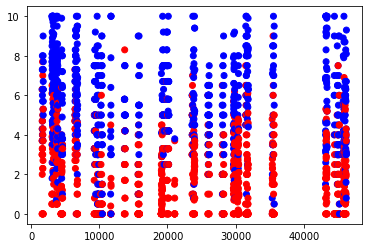

<Figure size 1440x576 with 0 Axes>

In [74]:
colors = ['red' if i else 'blue' for i in matriculas_c2.reprovou]
plt.scatter(matriculas_c2.index, matriculas_c2.nota, color=colors)
plt.figure(figsize=(20, 8))

In [75]:
matriculas_c2[matriculas_c2.historico_reprovacao == -1].shape

(889, 13)

## Feature 7: professor_c1

In [76]:
turmas.columns

Index(['id_turma', 'id_componente_curricular', 'id_docente_interno',
       'ano_periodo', 'tx_reprovacao', 'professor_tx_reprovao'],
      dtype='object')

In [77]:
matriculas_c2['prof_c1_tx_reprovacao'] = -1

In [78]:
lista_semestres_analisados = [20181, 20182, 20191, 20192]

tx_reprovacao_do_professor_por_turma = {}
for semestre in lista_semestres_analisados:
    turmas_anteriores = turmas.query(f"ano_periodo < {semestre}")
    matr_antigas = matriculas[matriculas.id_turma.isin(turmas_anteriores.id_turma.unique())]
    
    turmas_atuais = turmas.query(f"ano_periodo == {semestre}")
    matricula_atual = matriculas_c2[matriculas_c2.id_turma.isin(turmas_atuais.id_turma.unique())]
    for index, row in matricula_atual.iterrows():
        aluno_matr_ant = matr_antigas[matr_antigas.discente == row['discente']]
        aluno_turmas_ant = turmas_anteriores[turmas_anteriores.id_turma.isin(aluno_matr_ant.id_turma.unique())]
        aluno_turmas_ant = aluno_turmas_ant[aluno_turmas_ant.id_componente_curricular.isin(['48582', '57587', '2050801'])]
        if aluno_turmas_ant.shape[0] > 0:
            matriculas_c2.at[index, 'prof_c1_tx_reprovacao'] = aluno_turmas_ant.professor_tx_reprovao.mean()

<AxesSubplot:>

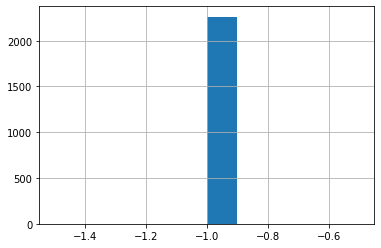

In [79]:
matriculas_c2.prof_c1_tx_reprovacao.hist()

In [80]:
media_prof_c1_tx_reprovacao = matriculas_c2[~matriculas_c2.prof_c1_tx_reprovacao.isna()].prof_c1_tx_reprovacao.mean()

matriculas_c2.prof_c1_tx_reprovacao.fillna(media_prof_c1_tx_reprovacao, inplace=True)

### Adionando a dificuldade do professor

In [81]:
matriculas_c2 = pd.merge(matriculas_c2, turmas[['id_turma', 'professor_tx_reprovao']], on='id_turma', how='left')

## Exportando os dados

In [82]:
matriculas_c2.shape

(2262, 15)

In [83]:
matriculas_c2.to_csv("data/matriculas_c2_pos_novos_indicadores.csv", sep=";", index=False)